In [23]:
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.stats import beta
import matplotlib
import pandas as pd
import csv


matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = False

num_samples = 1000

from models import BetaBernoulli, SumOfBetaEce, Model
from data_utils import datafile_dict, datasize_dict, num_classes_dict, prepare_data, num_classes_dict

In [59]:
# datafile = datafile_dict['cifar100']
# num_classes = 100
dataset = 'svhn'

datafile = datafile_dict[dataset]
num_classes = num_classes_dict[dataset]

categories, observations, confidences, idx2category, category2idx, labels = prepare_data(datafile, False)

In [60]:
# accuracy models
accuracy_model = copy.deepcopy(BetaBernoulli(k=num_classes, prior=None))
accuracy_model.update_batch(categories, observations)

# ece models for each class
ece_models = [SumOfBetaEce(num_bins=10, weight=None, prior_alpha=None, prior_beta=None) for i in range(num_classes)]
for class_idx in range(num_classes):
    mask_idx = [i for i in range(len(observations)) if categories[i] == class_idx]
    observations_sublist = [observations[i] for i in mask_idx]
    confidences_sublist = [confidences[i] for i in mask_idx]
    ece_models[class_idx].update_batch(confidences_sublist, observations_sublist)

In [61]:
# draw samples from posterior of classwise accuracy
accuracy_samples = accuracy_model.sample(num_samples) # (num_categories, num_samples)
ece_samples = np.array([ece_models[class_idx].sample(num_samples) 
                        for class_idx in range(num_classes)]).squeeze() # (num_categories, num_samples)

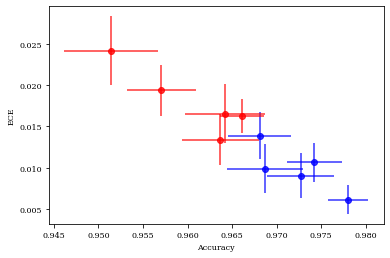

In [62]:
# plot
x = np.mean(accuracy_samples, axis=1)
y = np.mean(ece_samples, axis=1)
xerr = np.std(accuracy_samples, axis=1)
yerr = np.std(ece_samples, axis=1)

k = 5
# most accuracy top k
idx = x.argsort()[-k:][::-1]
plt.errorbar(x[idx], y[idx],
            xerr=xerr[idx],
            yerr=yerr[idx],
            fmt='o', alpha=0.8, color='b')

# least accuracy top k
idx = x.argsort()[:k]
plt.errorbar(x[idx], y[idx],
            xerr=xerr[idx],
            yerr=yerr[idx],
            fmt='o', alpha=0.8, color='r')

# other predicted classes
idx = x.argsort()[10:-k]
plt.errorbar(x[idx], y[idx],
            xerr=xerr[idx],
            yerr=yerr[idx],
            fmt='o', alpha=0.2, color='k')

plt.xlabel('Accuracy')
plt.ylabel('ECE')
plt.savefig('../figures/scatters/%s.pdf' % dataset)
plt.show()

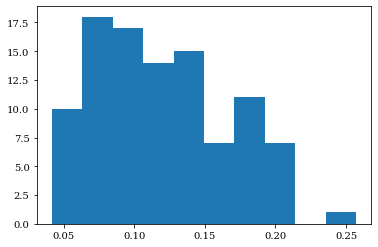

In [6]:
plt.hist(np.mean(ece_samples, axis=1));
plt.show()

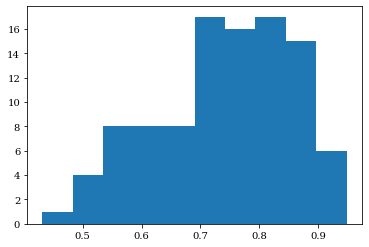

In [7]:
plt.hist(np.mean(accuracy_samples, axis=1));
plt.show()

# Bayesian ECE

In [8]:
def plot_bayesian_reliability_diagram(model, figname=None):
    
    params_alpha, params_beta = ece_model.get_params()
    mode_acc = (params_alpha - 1) / (params_alpha + params_beta - 2)
    beta_posterior_p025 = beta.ppf(0.025, params_alpha, params_beta)
    beta_posterior_p975 = beta.ppf(0.975, params_alpha, params_beta)
    
    error_upper = beta_posterior_p975 - mode_acc
    error_lower = mode_acc - beta_posterior_p025

    num_bins = mode_acc.shape[0]
    
    fig, ax1 = plt.subplots(figsize=(4, 4))
    color = 'tab:red'
    # ax1.grid(True)
    ax1.plot([i + 0.5 for i in range(num_bins)], mode_acc , c="r", linestyle="--")
    ax1.errorbar([i + 0.5 for i in range(num_bins)], mode_acc, yerr=(error_lower, error_upper), fmt='o', color='r')
    ax1.plot(np.linspace(0, 1, num_bins+1), linestyle="--", linewidth=3, c="gray")
    ax1.fill_between([i + 0.5 for i in range(num_bins)], mode_acc, \
                     np.linspace(0, 1, num_bins + 1)[:-1] + 0.05, color="gray", alpha=0.3)
                 
    ax1.set_xlim((0.0, num_bins))
    ax1.set_xlabel("Score(Model Confidence)", fontsize=14)
    ax1.set_xticks(range(num_bins + 1))
    ax1.set_xticklabels(["%.1f" % i for i in np.linspace(0, 1, num_bins + 1)])
    ax1.set_ylim((0.0, 1.0))
    ax1.set_ylabel("Accuracy", fontsize=14)
                 
    plt.tight_layout()
    # plt.savefig(figname)
    
def plot_posterior_ece(model, num_samples = 1000):
    fig, ax = plt.subplots(figsize=(4, 4))
    color = 'tab:red'
    samples = model.sample(num_samples)
    print(samples)
    ax.hist(samples,bins=100)

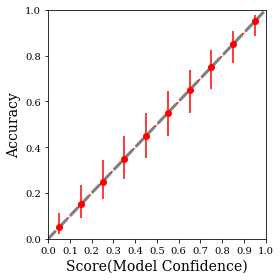

In [9]:
# prior reliability diagram
ece_model = SumOfBetaEce(num_bins = 10, pseudocount=100)

plot_bayesian_reliability_diagram(ece_model);
samples_prior = ece_model.sample(num_samples)

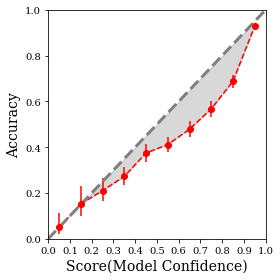

In [10]:
ece_model.update_batch(confidences, observations)
plot_bayesian_reliability_diagram(ece_model);
samples_posterior = ece_model.sample(num_samples)
# plot_posterior_ece(ece_model, num_samples = 10000)

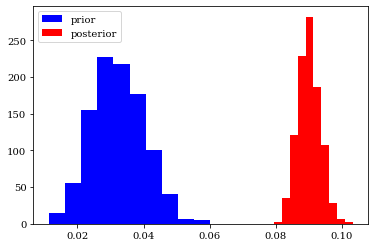

In [11]:
plt.hist(samples_prior, color = 'blue', label='prior')
plt.hist(samples_posterior, color = 'red', label='posterior')
plt.legend()